In [ ]:
# Basic data handling
import pandas as pd
import numpy as np

# Dataset
from sklearn.datasets import load_breast_cancer

# Preprocessing & splitting
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler

# Models
from sklearn.neighbors import KNeighborsClassifier

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dimensionality reduction
from sklearn.decomposition import PCA

# Multicollinearity (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Upload manually
from google.colab import files   # if you're using Colab
uploaded = files.upload()


Saving heart_disease_uci.csv to heart_disease_uci (5).csv


In [ ]:
df = pd.read_csv("heart_disease_uci.csv")

In [ ]:
df.shape

(920, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [ ]:
df.dtypes

,0
id,int64
age,int64
sex,object
dataset,object
cp,object
trestbps,float64
chol,float64
fbs,object
restecg,object
thalch,float64


In [ ]:
print("\nColumns:\n", df.columns.tolist())
print("\nMissing values per column:\n", df.isna().sum())


Columns:
 ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

Missing values per column:
 id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


In [ ]:
df_proc = df.copy()
for col in ['id', 'dataset']:
    if col in df_proc.columns:
        df_proc = df_proc.drop(columns=[col])
print("Remaining columns:", df_proc.columns.tolist())


Remaining columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


In [ ]:
# numeric columns (exclude the target 'num' if present)
num_cols = df_proc.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'num' in num_cols:
    num_cols.remove('num')

for col in num_cols:
    df_proc[col] = df_proc[col].fillna(df_proc[col].median())

# categorical columns
cat_cols = df_proc.select_dtypes(include=['object', 'bool']).columns.tolist()
for col in cat_cols:
    df_proc[col] = df_proc[col].fillna(df_proc[col].mode()[0])

print("Missing values after imputation:\n", df_proc.isna().sum())


Missing values after imputation:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


/tmp/ipython-input-4025573782.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_proc[col] = df_proc[col].fillna(df_proc[col].mode()[0])


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,920.0,460.500000,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,53.510870,9.424685,28.0,47.00,54.0,60.00,77.0
trestbps,861.0,132.132404,19.066070,0.0,120.00,130.0,140.00,200.0
chol,890.0,199.130337,110.780810,0.0,175.00,223.0,268.00,603.0
thalch,865.0,137.545665,25.926276,60.0,120.00,140.0,157.00,202.0
oldpeak,858.0,0.878788,1.091226,-2.6,0.00,0.5,1.50,6.2
ca,309.0,0.676375,0.935653,0.0,0.00,0.0,1.00,3.0
num,920.0,0.995652,1.142693,0.0,0.00,1.0,2.00,4.0


In [ ]:
df['num'].value_counts()
df['num'].value_counts(normalize=True) * 100  # percentage

,proportion
num,
0,44.673913
1,28.804348
2,11.847826
3,11.630435
4,3.043478


In [ ]:
for col in df.columns:
    print(col, ":", df[col].nunique())


id : 920
age : 50
sex : 2
dataset : 4
cp : 4
trestbps : 61
chol : 217
fbs : 2
restecg : 3
thalch : 119
exang : 2
oldpeak : 53
slope : 3
ca : 4
thal : 3
num : 5


In [ ]:
# Function to calculate % of outliers per column using IQR
def outlier_percentage_iqr(df):
    outlier_info = {}
    for col in df.select_dtypes(include=[np.number]).columns:  # numeric cols only
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Count outliers
        outliers = df[(df[col] < lower) | (df[col] > upper)][col]
        percent = 100 * len(outliers) / len(df)
        outlier_info[col] = round(percent, 2)

    return pd.DataFrame.from_dict(outlier_info, orient='index', columns=['% Outliers'])

# Run the function
outlier_percentage_iqr(df_proc)

,% Outliers
age,0.00
trestbps,3.04
chol,20.11
thalch,0.22
oldpeak,1.74
ca,13.91
num,0.00


In [ ]:
# Skewness check for numeric columns
skew_vals = df.select_dtypes(include=[np.number]).skew()

# Sort by highest skewness
skew_df = skew_vals.sort_values(ascending=False).to_frame(name='Skewness')
print(skew_df)

# Optional: see only highly skewed
print(skew_df[abs(skew_df['Skewness']) > 1])  # threshold >1 means high skew


          Skewness
ca        1.165978
oldpeak   1.041427
num       0.968880
trestbps  0.213334
id        0.000000
age      -0.195994
thalch   -0.211119
chol     -0.613836
         Skewness
ca       1.165978
oldpeak  1.041427


In [ ]:
#Create binary target (target): 0 = no disease, 1 = disease
df_proc['target'] = (df_proc['num'] > 0).astype(int)
df_proc = df_proc.drop(columns=['num'])
print(df_proc['target'].value_counts())


target
1    509
0    411
Name: count, dtype: int64


In [ ]:
#Encode categorical variables (one-hot)
cat_cols = df_proc.select_dtypes(include=['object', 'bool']).columns.tolist()
print("Categorical columns:", cat_cols)

# one-hot encode (keeps all categories)
df_encoded = pd.get_dummies(df_proc, columns=cat_cols, drop_first=False)
print("Encoded shape:", df_encoded.shape)


Categorical columns: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Encoded shape: (920, 26)


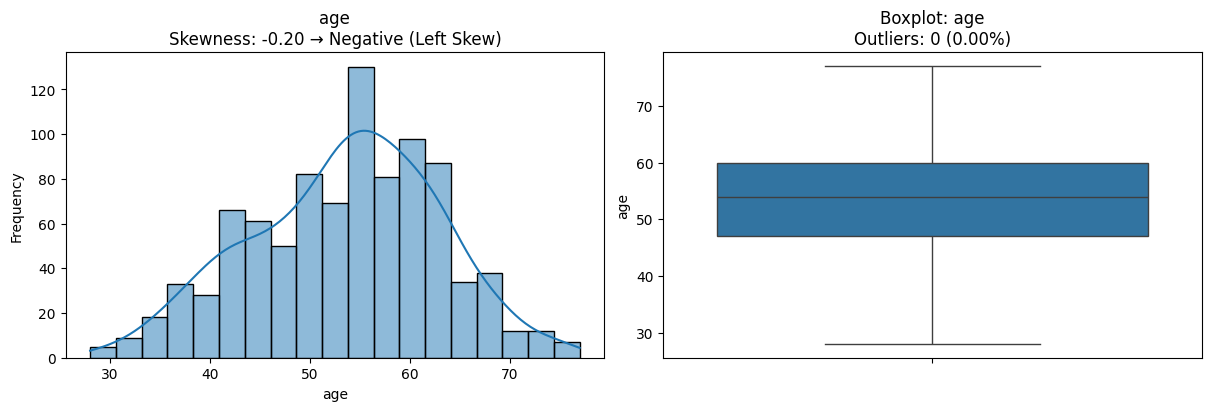

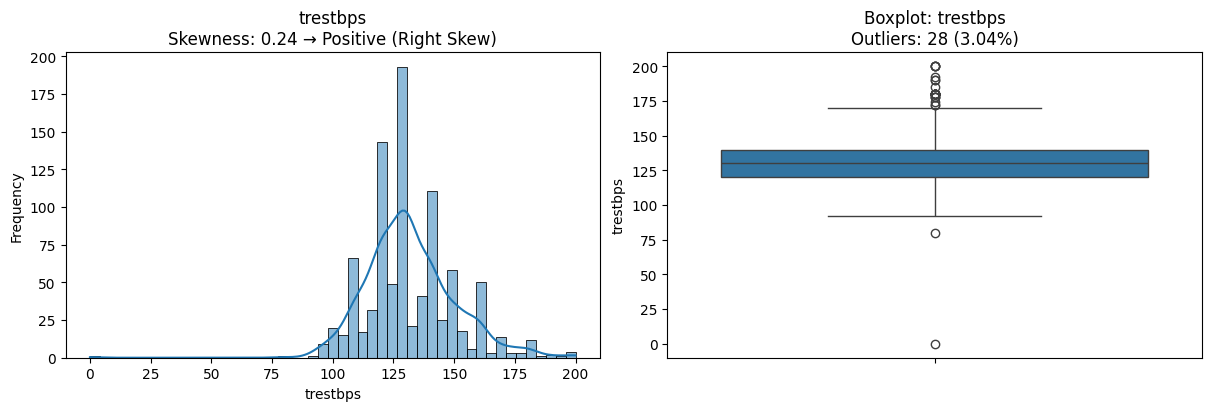

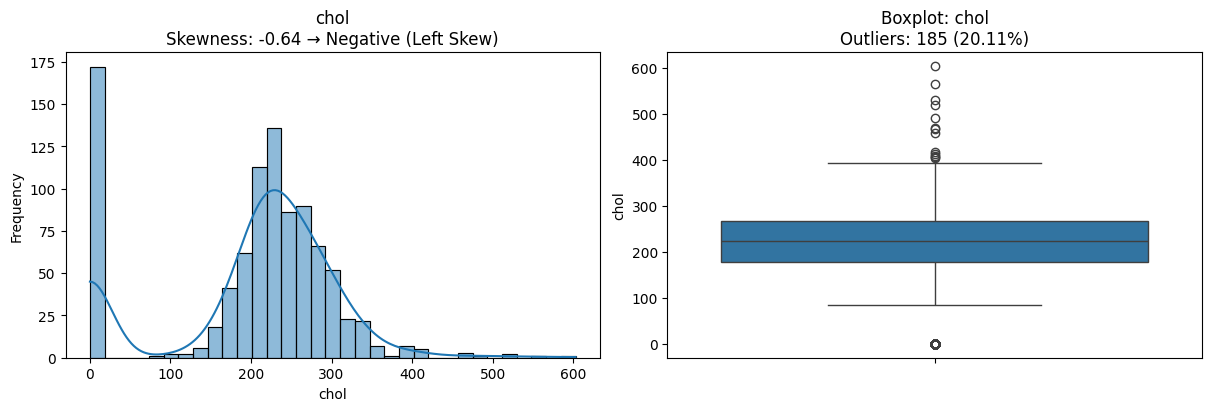

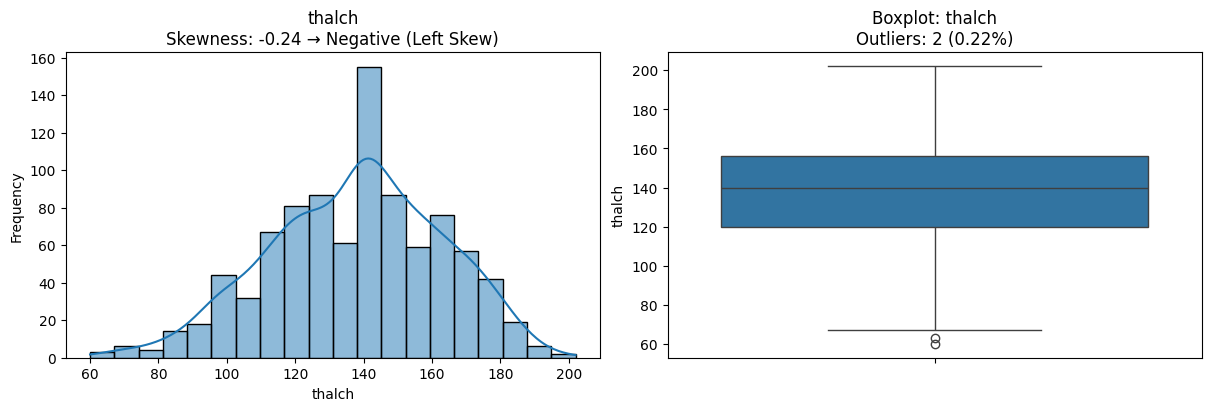

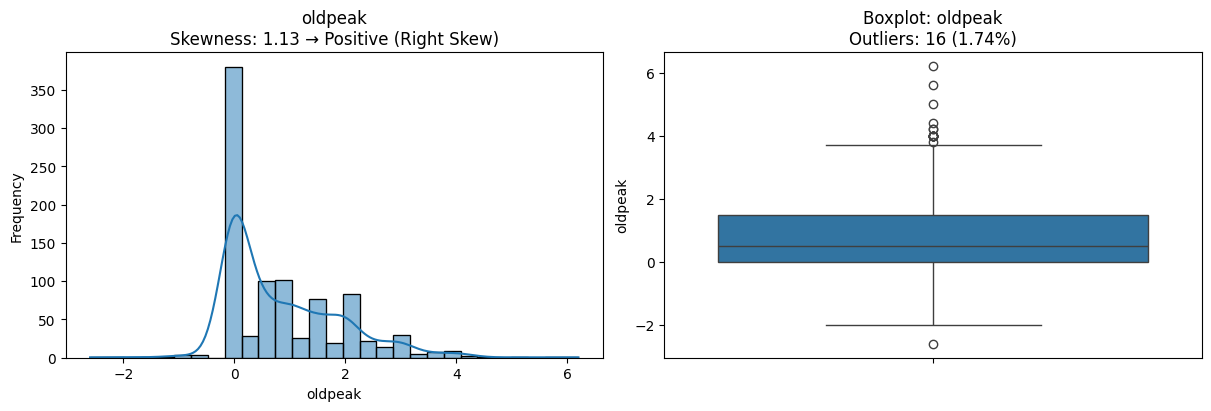

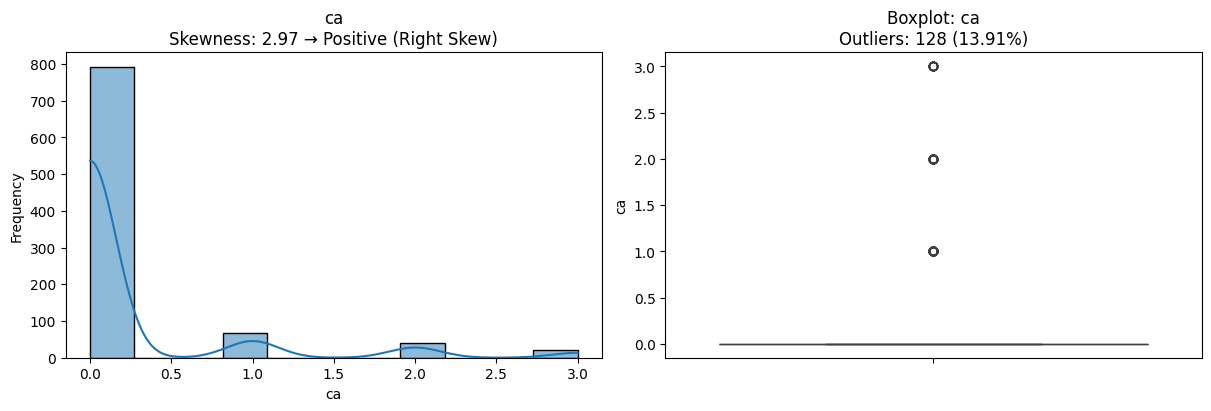

In [ ]:
for col in df_proc.select_dtypes(include=[np.number]).columns[:6]:  # first 6 numeric cols
    s = df_proc[col].dropna()
    skew_val = s.skew()

    # Decide skew type
    if skew_val > 0:
        skew_type = "Positive (Right Skew)"
    elif skew_val < 0:
        skew_type = "Negative (Left Skew)"
    else:
        skew_type = "Symmetric"

    # ---- IQR Outlier Detection ----
    Q1, Q3 = s.quantile(0.25), s.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = s[(s < lower) | (s > upper)]
    n_out = len(outliers)
    pct_out = 100 * n_out / len(s)

    # ---- Plot: Histogram + Boxplot ----
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # Histogram with KDE
    sns.histplot(s, kde=True, ax=axes[0])
    axes[0].set_title(f"{col}\nSkewness: {skew_val:.2f} → {skew_type}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frequency")

    # Boxplot with outlier info
    sns.boxplot(y=s, ax=axes[1])
    axes[1].set_title(f"Boxplot: {col}\nOutliers: {n_out} ({pct_out:.2f}%)")
    axes[1].set_ylabel(col)

    plt.show()

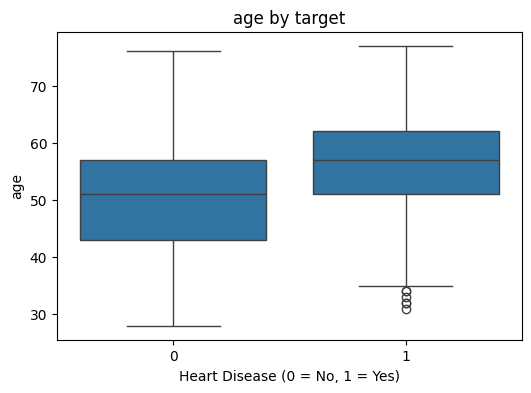

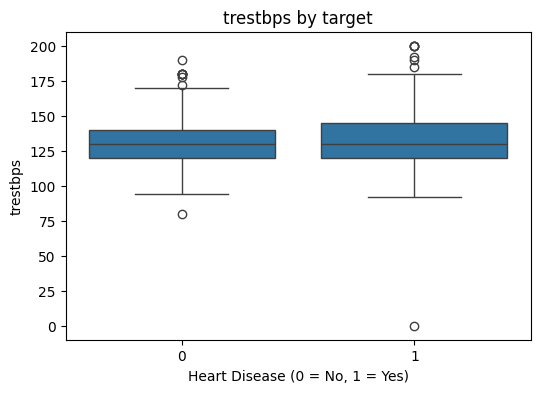

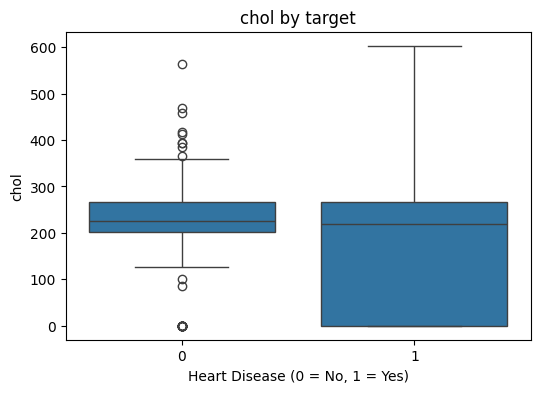

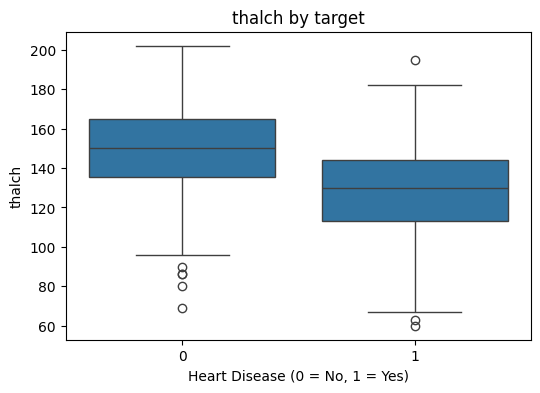

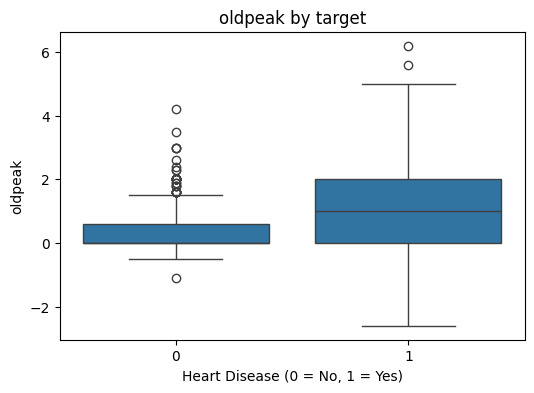

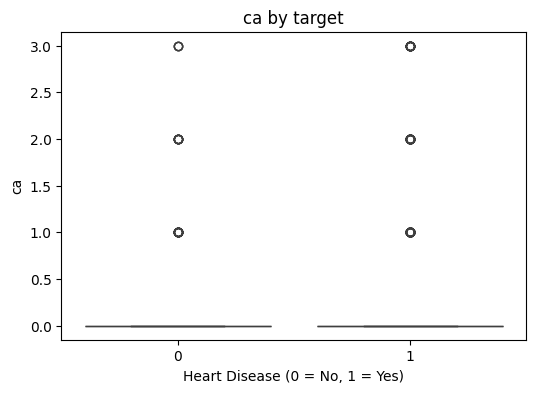

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Target column for heart disease dataset
target = "target"   # 0 = No disease, 1 = Disease

# Make sure you already created df_encoded (after preprocessing and encoding)
# If not, replace df_encoded with your dataframe variable (e.g., df_knn or df_proc)

for col in df_encoded.select_dtypes(include=[np.number]).columns:
    # Skip the target column itself
    if col == target:
        continue

    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_encoded[target], y=df_encoded[col])
    plt.title(f"{col} by {target}")
    plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
    plt.ylabel(col)
    plt.show()


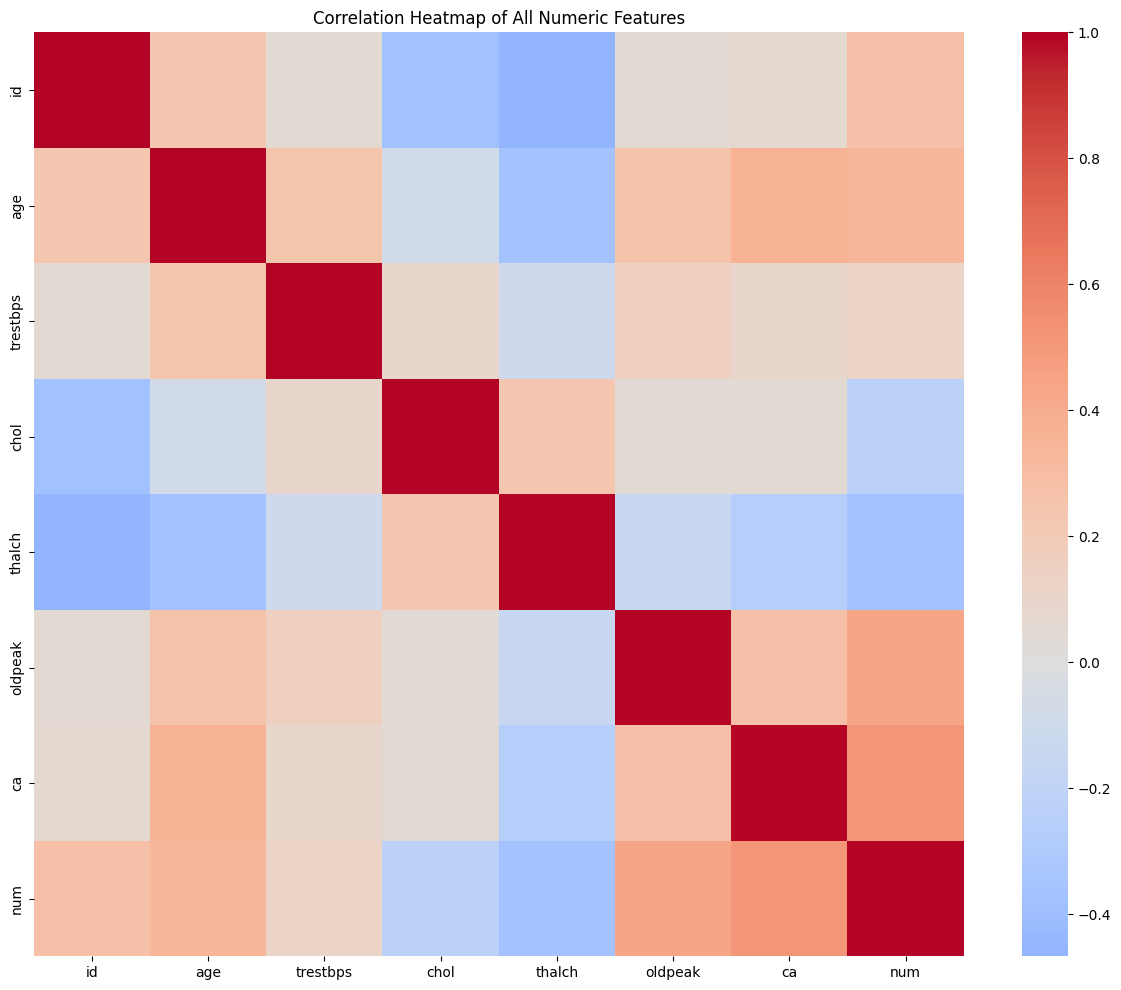

In [ ]:
plt.figure(figsize=(15,12))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap of All Numeric Features")
plt.show()


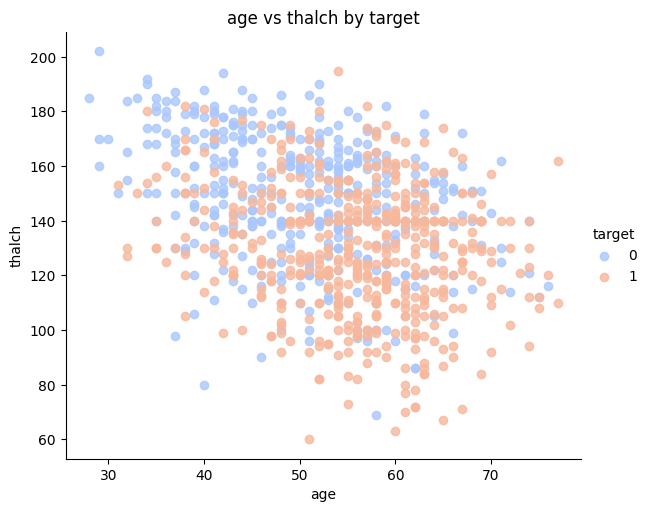

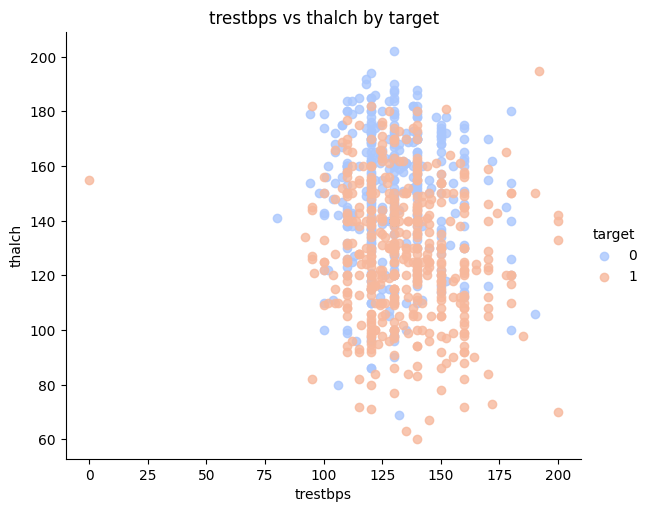

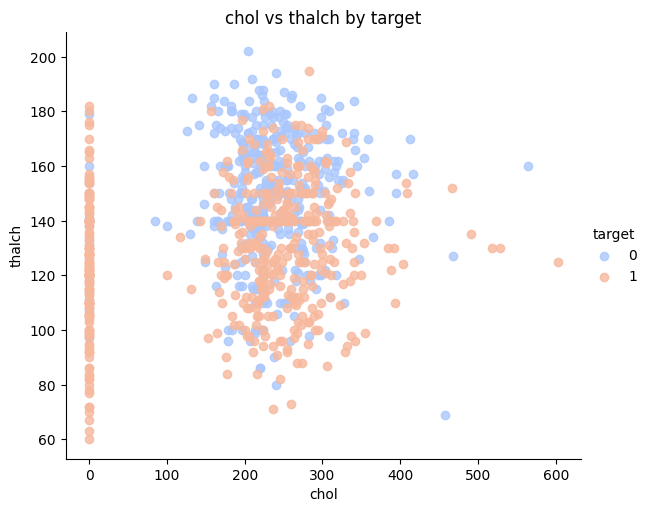

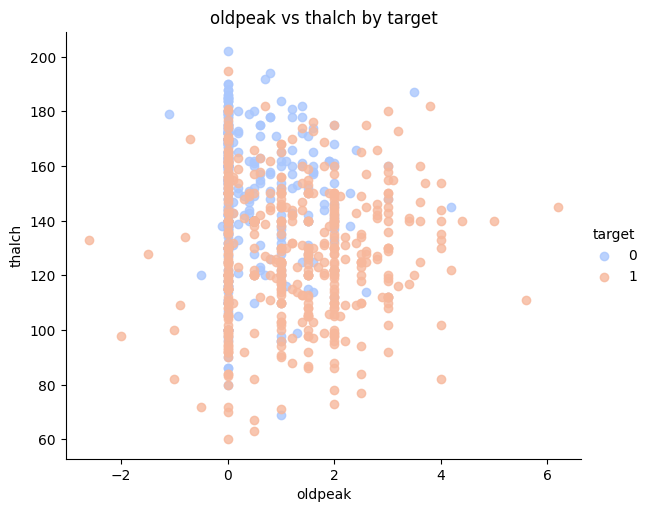

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Target column for heart disease dataset
target = "target"   # 0 = No disease, 1 = Disease

# 🔹 Choose numeric features you want to visualize
# You can adjust this list based on importance or correlation with target
top_features = ["age", "trestbps", "chol", "thalch", "oldpeak"]

# 🔹 Pick one feature to compare against (like “thalch” or “oldpeak”)
compare_with = "thalch"   # X-axis variable to compare with

for col in top_features:
    if col == compare_with:   # skip comparing the same feature with itself
        continue

    sns.lmplot(
        data=df_encoded,
        x=col,
        y=compare_with,
        hue=target,
        fit_reg=False,
        height=5,
        aspect=1.2,
        palette="coolwarm"
    )
    plt.title(f"{col} vs {compare_with} by {target}")
    plt.xlabel(col)
    plt.ylabel(compare_with)
    plt.show()



## Multivariate analysis

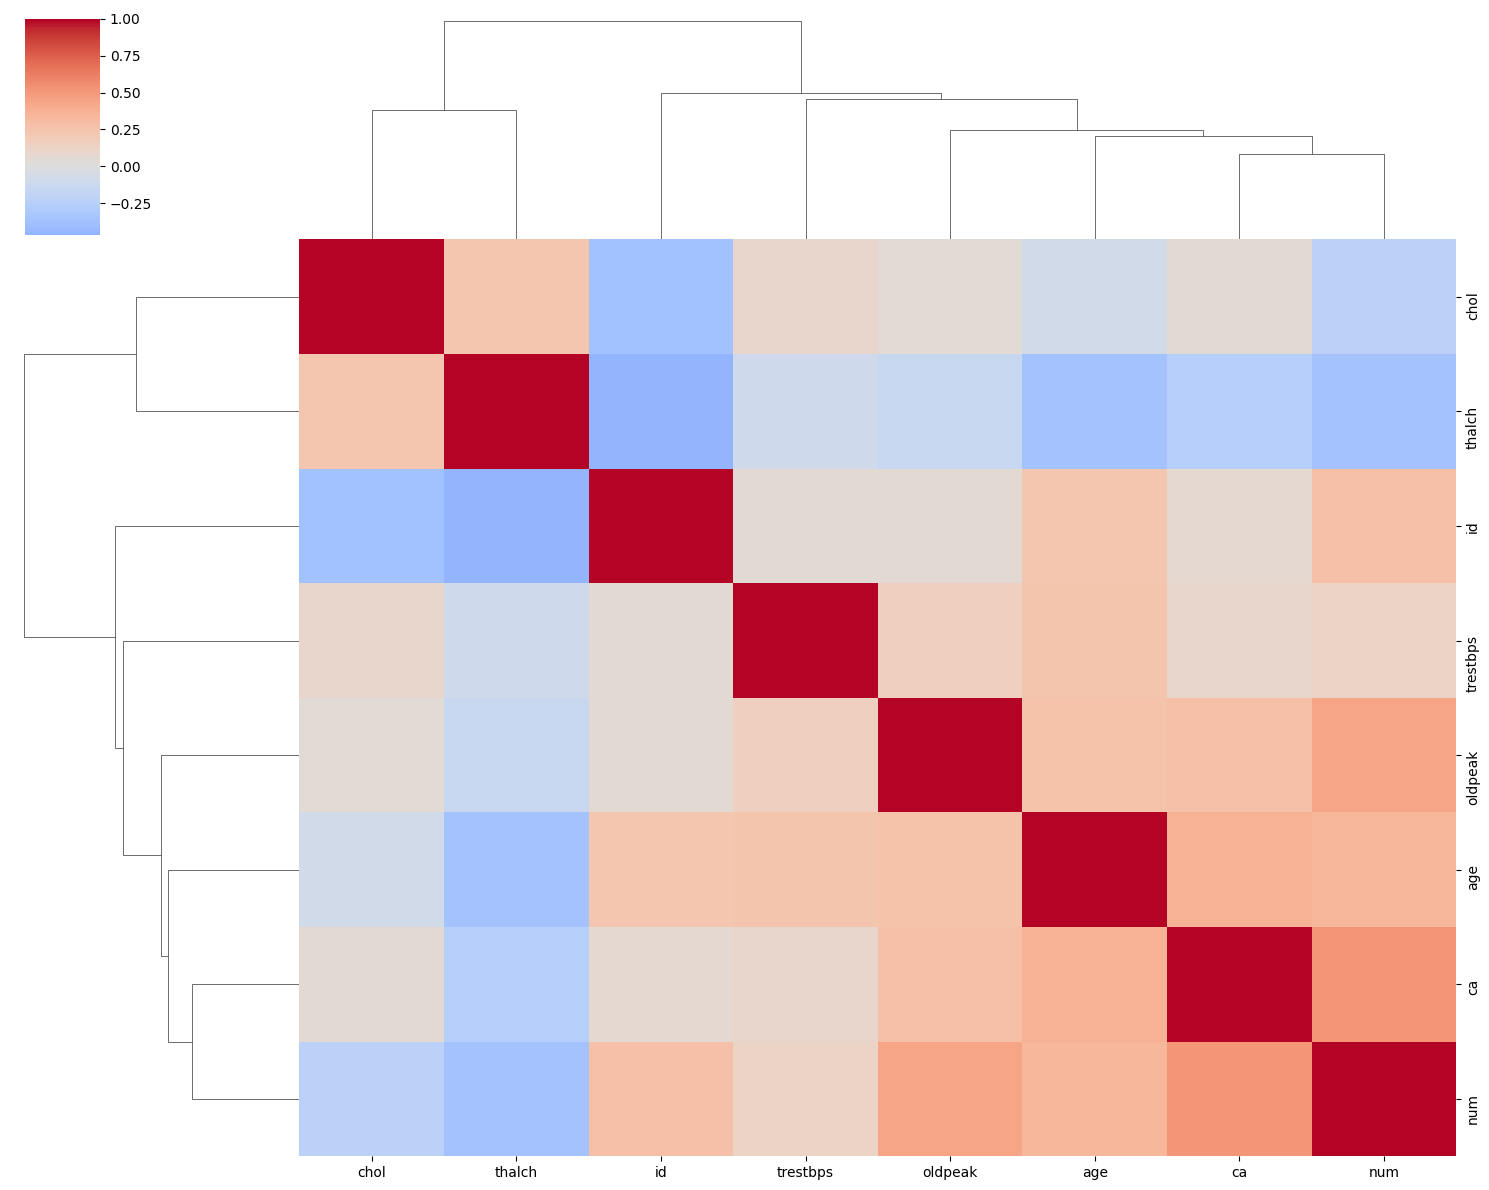

In [ ]:
sns.clustermap(
    corr,
    cmap="coolwarm",
    center=0,
    figsize=(15,12)
)


In [ ]:
# 📌 Curse of Dimensionality
# ---------------------------
# KNN and other distance-based models can struggle with many features:
# - Data gets sparse → distances become less meaningful.
# - Redundant features (highly correlated) add noise without new information.
# - Computation becomes expensive as dimensions increase.
# 👉 Solution: check correlations and remove/reduce redundancy.

# 📊 Correlation Check (Non-Graphical) for high correlations
import pandas as pd

# Get absolute correlation matrix
corr_matrix = df_encoded.select_dtypes(include=[np.number]).corr().abs()

# Unstack to get feature pairs
corr_unstacked = corr_matrix.unstack().sort_values(ascending=False)

# Remove self-correlations (value = 1.0)
corr_filtered = corr_unstacked[corr_unstacked < 0.999]

# Filter for pairs with correlation > 0.5
high_corr = corr_filtered[corr_filtered > 0.5]

print("🔎 All feature pairs with correlation > 0.5 (non-graphical):\n")
print(high_corr)

🔎 All feature pairs with correlation > 0.5 (non-graphical):

Series([], dtype: float64)


In [ ]:
# Get correlation matrix (absolute values)
corr_matrix = df.select_dtypes(include=[np.number]).corr().abs()

# Show top correlated pairs
corr_unstacked = corr_matrix.unstack().sort_values(ascending=False)

# Remove self-correlations (1.0 on diagonal)
corr_filtered = corr_unstacked[corr_unstacked < 0.999]

# Display top 10 strongest correlations
print("🔎 Top 10 correlated feature pairs (non-graphical):\n")
print(corr_filtered.head(10))

🔎 Top 10 correlated feature pairs (non-graphical):

num      ca         0.516216
ca       num        0.516216
id       thalch     0.466427
thalch   id         0.466427
oldpeak  num        0.443084
num      oldpeak    0.443084
id       chol       0.376936
chol     id         0.376936
ca       age        0.370416
age      ca         0.370416
dtype: float64


In [ ]:
# 📌 Variance Inflation Factor (VIF) Check
# ----------------------------------------
# VIF > 5 → moderate multicollinearity
# VIF > 10 → severe multicollinearity (feature may need removal)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Select numeric features from the processed dataframe
X = df_proc.select_dtypes(include=[np.number])

# Add constant for statsmodels
X_const = add_constant(X)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                   for i in range(X_const.shape[1])]

# Drop the constant row
vif_data = vif_data[vif_data["Feature"] != "const"]

print("🔎 Variance Inflation Factor (VIF) for all numeric features:\n")
print(vif_data.sort_values("VIF", ascending=False))

🔎 Variance Inflation Factor (VIF) for all numeric features:

    Feature       VIF
7    target  1.422617
4    thalch  1.323622
1       age  1.301193
5   oldpeak  1.236946
6        ca  1.153996
3      chol  1.153711
2  trestbps  1.087241


In [ ]:
# Columns that need capping
cols_to_cap = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

df_winsor = df.copy()

for col in cols_to_cap:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    bc_df_winsor[col] = np.clip(df[col], lower, upper)

print("Capped columns:", cols_to_cap)


Capped columns: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']


In [ ]:
#Compare Descriptive Stats Before vs After Capping
# Compare descriptive statistics before vs after capping
print("Before capping:\n")
print(df_encoded[['age', 'trestbps', 'chol', 'thalch', 'oldpeak']].describe().T[['min','25%','50%','75%','max']])

print("\nAfter capping:\n")
print(df_winsor[['age', 'trestbps', 'chol', 'thalch', 'oldpeak']].describe().T[['min','25%','50%','75%','max']])


Before capping:

           min     25%    50%    75%    max
age       28.0   47.00   54.0   60.0   77.0
trestbps   0.0  120.00  130.0  140.0  200.0
chol       0.0  177.75  223.0  267.0  603.0
thalch    60.0  120.00  140.0  156.0  202.0
oldpeak   -2.6    0.00    0.5    1.5    6.2

After capping:

           min    25%    50%    75%    max
age       28.0   47.0   54.0   60.0   77.0
trestbps   0.0  120.0  130.0  140.0  200.0
chol       0.0  175.0  223.0  268.0  603.0
thalch    60.0  120.0  140.0  157.0  202.0
oldpeak   -2.6    0.0    0.5    1.5    6.2


In [ ]:
# Recalculate outlier % on winsorized data
outlier_check = outlier_percentage_iqr(df_winsor)
print(outlier_check.loc[['age', 'trestbps', 'chol', 'thalch', 'oldpeak']])


          % Outliers
age             0.00
trestbps        3.04
chol           19.89
thalch          0.22
oldpeak         1.74


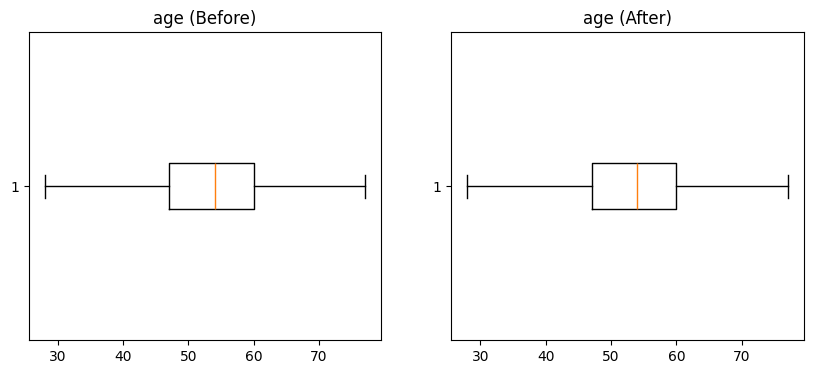

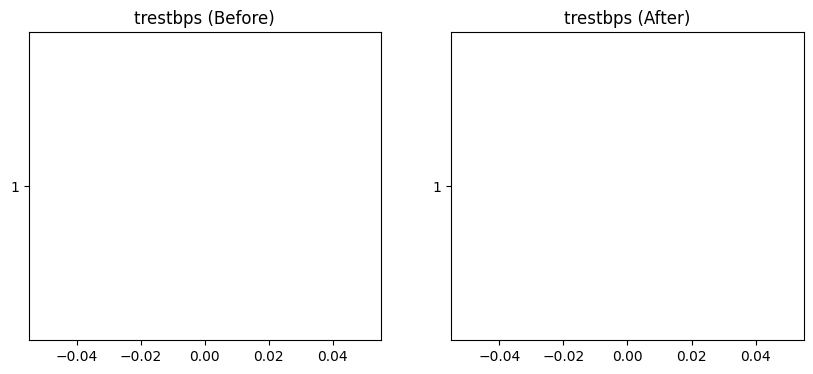

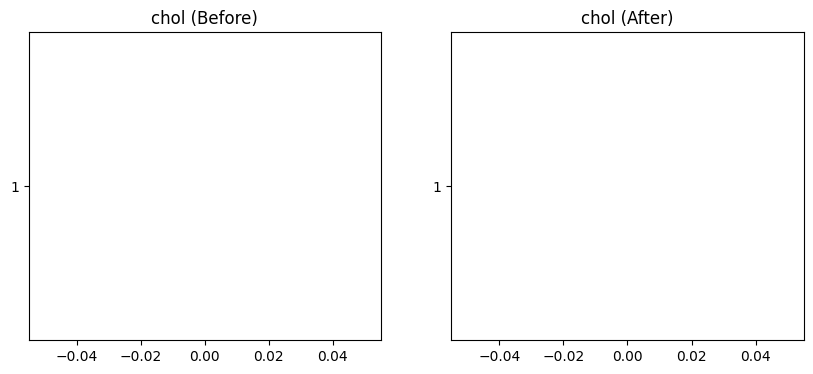

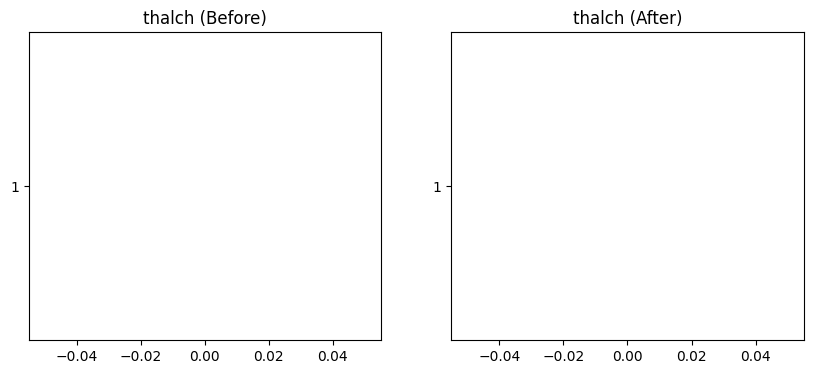

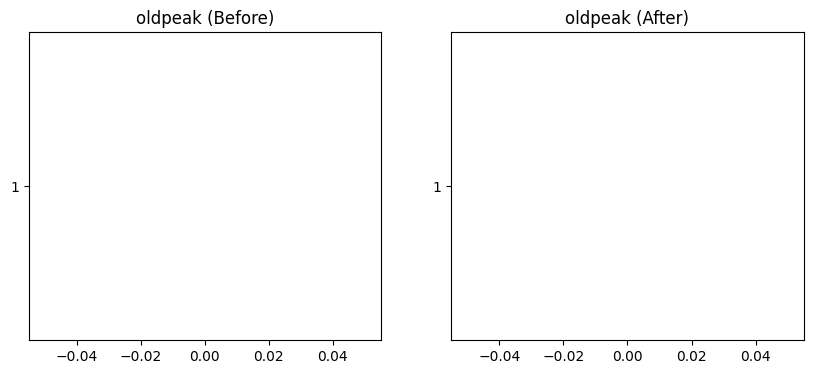

In [ ]:
cols_to_plot = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

for col in cols_to_plot:
    fig, axes = plt.subplots(1,2, figsize=(10,4))

    axes[0].boxplot(df[col], vert=False)
    axes[0].set_title(f"{col} (Before)")

    axes[1].boxplot(df_winsor[col], vert=False)
    axes[1].set_title(f"{col} (After)")

    plt.show()


## Encode Target

In [ ]:
# Before encoding (Heart Disease UCI Dataset)
print("Before encoding:")
print("Unique values in target:", df_proc["target"].unique())
print("Value counts:\n", df_proc["target"].value_counts())
print("dtype of target:", df_proc["target"].dtype)

Before encoding:
Unique values in target: [0 1]
Value counts:
 target
1    509
0    411
Name: count, dtype: int64
dtype of target: int64


In [ ]:
# Encode target into numeric labels (Heart Disease UCI Dataset)
# Note: The 'target' column in df_proc is already numeric (0 and 1),
# so this encoding step is not strictly necessary but shown for clarity.
y = (df_proc["target"]
       .astype(str)   # ensure it's string for safe mapping
       .str.strip()   # remove any accidental spaces
       .map({"0": 0, "1": 1})  # map to numeric values
       .astype("int64"))

# After encoding
print("\nAfter encoding:")
print("Unique values in y:", y.unique())
print("Value counts:\n", y.value_counts())
print("y dtype:", y.dtype)


After encoding:
Unique values in y: [0 1]
Value counts:
 target
1    509
0    411
Name: count, dtype: int64
y dtype: int64


## Split Features & Target

In [ ]:
# Drop target column and keep only numeric features (Heart Disease UCI Dataset)
X = (df_winsor
       .drop(columns=["target"], errors="ignore")   # remove target column
       .select_dtypes(include="number"))            # keep only numeric features

# Sanity check
print("Columns in X:", X.columns.tolist())
print("'target' in X?", "target" in X.columns)
print("X non-numeric dtypes:\n", X.select_dtypes(exclude="number").dtypes)


Columns in X: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num']
'target' in X? False
X non-numeric dtypes:
 Series([], dtype: object)


## Scale Features

KNN requires scaling because it’s distance-based.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X_scaled shape:", X_scaled.shape)



X_scaled shape: (920, 8)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

def reduce_vif(X, thresh=10.0):
    """
    Iteratively drops the feature with the highest VIF until all are below threshold.
    Returns:
        - reduced dataset
        - list of dropped features with their VIFs
    """
    variables = X.columns.tolist()
    dropped_features = []

    while True:
        X_const = add_constant(X[variables])
        vif = [variance_inflation_factor(X_const.values, i)
               for i in range(X_const.shape[1])]

        # Ignore constant (first element)
        max_vif = max(vif[1:])
        if max_vif > thresh:
            maxloc = vif[1:].index(max_vif) + 1
            feature_to_drop = variables[maxloc-1]
            print(f"Dropping {feature_to_drop} with VIF={max_vif:.2f}")
            dropped_features.append((feature_to_drop, max_vif))
            variables.pop(maxloc-1)
        else:
            break

    return X[variables], pd.DataFrame(dropped_features, columns=["Dropped Feature", "VIF"])


In [ ]:
#https://fastercapital.com/content/Model-selection--Guiding-Model-Selection-using-Variance-Inflation-Factor.html
# Select numeric features from the processed dataframe after imputation
X = df_proc.select_dtypes(include=[np.number]).drop(columns=['target'])

# Scale the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled array back to DataFrame with feature names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Run automated stepwise VIF reduction
X_vif_reduced, dropped_vif_summary = reduce_vif(X_scaled_df, thresh=10)

print("\n✅ Final features after VIF reduction:", list(X_vif_reduced.columns))
print("\n📉 Dropped features summary:")
print(dropped_vif_summary)


✅ Final features after VIF reduction: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

📉 Dropped features summary:
Empty DataFrame
Columns: [Dropped Feature, VIF]
Index: []


## Check Dropped Features

In [ ]:
print("📉 Dropped features due to high VIF:\n")
print(dropped_vif_summary)


📉 Dropped features due to high VIF:

Empty DataFrame
Columns: [Dropped Feature, VIF]
Index: []


## Check Remaining Features

In [ ]:
print("\n✅ Remaining features count:", X_vif_reduced.shape[1])
print("Remaining features:\n", list(X_vif_reduced.columns))



✅ Remaining features count: 6
Remaining features:
 ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']


## Re-check Final VIFs

In [ ]:
X_const = add_constant(X_vif_reduced)
final_vif = pd.DataFrame()
final_vif["Feature"] = X_vif_reduced.columns
final_vif["VIF"] = [variance_inflation_factor(X_const.values, i+1)
                    for i in range(len(X_vif_reduced.columns))]

print("\n📊 Final VIF values after reduction:\n", final_vif)



📊 Final VIF values after reduction:
     Feature       VIF
0       age  1.294097
1  trestbps  1.086502
2      chol  1.098939
3    thalch  1.218102
4   oldpeak  1.119709
5        ca  1.131411


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': list(range(1, 21)),   # tune k from 1 to 20
    'knn__weights': ['uniform', 'distance']
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,       # use multiple cores if available
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'knn__n_neighbors': 20, 'knn__weights': 'uniform'}
Best CV accuracy: 0.7663173377459093


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_vif_reduced, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Initialize and train KNN (start with k=15)
knn_vif = KNeighborsClassifier(n_neighbors=5)
knn_vif.fit(X_train, y_train)

# 3. Make predictions
y_pred_vif = knn_vif.predict(X_test)

# 4. Evaluate model
print("📊 KNN After VIF Reduction")
print("Accuracy:", accuracy_score(y_test, y_pred_vif))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_vif))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vif))


📊 KNN After VIF Reduction
Accuracy: 0.7228260869565217

Confusion Matrix:
 [[56 26]
 [25 77]]

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.68      0.69        82
           1       0.75      0.75      0.75       102

    accuracy                           0.72       184
   macro avg       0.72      0.72      0.72       184
weighted avg       0.72      0.72      0.72       184



##  KNN After PCA

In [ ]:
from sklearn.decomposition import PCA

# PCA with enough components to explain 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

Xp_train, Xp_test, yp_train, yp_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

knn_pca = KNeighborsClassifier(n_neighbors=15)
knn_pca.fit(Xp_train, yp_train)
y_pred_pca = knn_pca.predict(Xp_test)

print("\n📊 KNN After PCA")
print("Accuracy:", accuracy_score(yp_test, y_pred_pca))
print("\nConfusion Matrix:\n", confusion_matrix(yp_test, y_pred_pca))
print("\nClassification Report:\n", classification_report(yp_test, y_pred_pca))



📊 KNN After PCA
Accuracy: 0.7880434782608695

Confusion Matrix:
 [[61 21]
 [18 84]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76        82
           1       0.80      0.82      0.81       102

    accuracy                           0.79       184
   macro avg       0.79      0.78      0.78       184
weighted avg       0.79      0.79      0.79       184



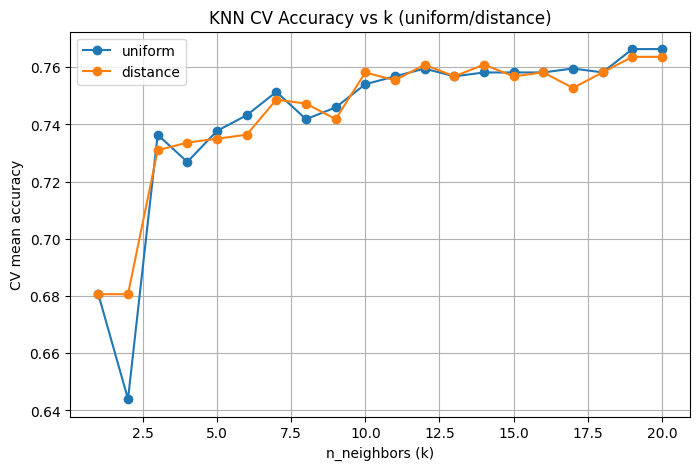

In [ ]:
#(Optional) Plot CV mean accuracy vs k for both weight options
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['k'] = cv_results['param_knn__n_neighbors'].astype(int)
cv_results['weights'] = cv_results['param_knn__weights'].astype(str)

pivot = cv_results.pivot_table(values='mean_test_score', index='k', columns='weights')

plt.figure(figsize=(8,5))
plt.plot(pivot.index, pivot['uniform'], marker='o', label='uniform')
plt.plot(pivot.index, pivot['distance'], marker='o', label='distance')
plt.xlabel('n_neighbors (k)')
plt.ylabel('CV mean accuracy')
plt.title('KNN CV Accuracy vs k (uniform/distance)')
plt.legend()
plt.grid(True)
plt.show()


(Optional) Save trained model & scaler (joblib)

In [ ]:
import joblib
joblib.dump(grid.best_estimator_, "knn_heart_model.pkl")
print("Saved model to knn_heart_model.pkl")

Saved model to knn_heart_model.pkl


In [ ]:
grid = GridSearchCV(pipeline,
                    {'knn__n_neighbors': list(range(1, 11)),
                     'knn__weights': ['uniform', 'distance']},
                    cv=3, scoring='accuracy', n_jobs=4, verbose=1)


In [ ]:
# =========================================================
# GridSearchCV for KNN (Heart Disease UCI dataset)
# =========================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---------------------------------------------------------
# 1) Split data into train-test
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------------------------------------
# 2) Create a pipeline: scaling + KNN
# ---------------------------------------------------------
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# ---------------------------------------------------------
# 3) Define grid for k values
# ---------------------------------------------------------
param_grid = {
    'knn__n_neighbors': list(range(1, 12)),   # k = 1..11
    'knn__weights': ['uniform', 'distance']   # optional: compare both weighting types
}

# ---------------------------------------------------------
# 4) GridSearchCV setup (3-fold CV)
# ---------------------------------------------------------
grid = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# ---------------------------------------------------------
# 5) Fit the GridSearch on TRAIN data
# ---------------------------------------------------------
grid.fit(X_train, y_train)

# ---------------------------------------------------------
# 6) Display results
# ---------------------------------------------------------
print("✅ Best Parameters Found:")
print(grid.best_params_)
print("\nBest CV Accuracy:", round(grid.best_score_, 4))

# ---------------------------------------------------------
# 7) Evaluate on TEST data
# ---------------------------------------------------------
y_pred = grid.predict(X_test)

print("\n🎯 Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))


Fitting 3 folds for each of 22 candidates, totalling 66 fits
✅ Best Parameters Found:
{'knn__n_neighbors': 10, 'knn__weights': 'uniform'}

Best CV Accuracy: 0.7513

🎯 Test Accuracy: 0.7554

Confusion Matrix:
 [[61 21]
 [24 78]]

Classification Report:
               precision    recall  f1-score   support

           0      0.718     0.744     0.731        82
           1      0.788     0.765     0.776       102

    accuracy                          0.755       184
   macro avg      0.753     0.754     0.753       184
weighted avg      0.757     0.755     0.756       184



XGBoost + GridSearchCV (light version)

In [ ]:
# =========================================================
# GridSearchCV for XGBoost (Heart Disease UCI dataset)
# =========================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# ---------------------------------------------------------
# 1) Split the data
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------------------------------------
# 2) Create a pipeline (scaling + XGBoost)
# ---------------------------------------------------------
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),    # scaling (good for numerical stability)
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# ---------------------------------------------------------
# 3) Define a LIGHT parameter grid
# ---------------------------------------------------------
param_grid = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0]
}

# ---------------------------------------------------------
# 4) GridSearchCV setup
# ---------------------------------------------------------
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# ---------------------------------------------------------
# 5) Fit the grid search on TRAIN data
# ---------------------------------------------------------
grid_xgb.fit(X_train, y_train)

# ---------------------------------------------------------
# 6) Display results
# ---------------------------------------------------------
print("✅ Best Parameters Found:")
print(grid_xgb.best_params_)
print("\nBest CV Accuracy:", round(grid_xgb.best_score_, 4))

# ---------------------------------------------------------
# 7) Evaluate on TEST data
# ---------------------------------------------------------
y_pred = grid_xgb.predict(X_test)

print("\n🎯 Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))


Fitting 3 folds for each of 54 candidates, totalling 162 fits
✅ Best Parameters Found:
{'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}

Best CV Accuracy: 0.765

🎯 Test Accuracy: 0.7446

Confusion Matrix:
 [[58 24]
 [23 79]]

Classification Report:
               precision    recall  f1-score   support

           0      0.716     0.707     0.712        82
           1      0.767     0.775     0.771       102

    accuracy                          0.745       184
   macro avg      0.742     0.741     0.741       184
weighted avg      0.744     0.745     0.744       184



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:09:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
param_grid = {
    'xgb__n_estimators': [100],
    'xgb__max_depth': [3, 5],
    'xgb__learning_rate': [0.05, 0.1],
}


XGBoost with GridSearch + ROC + Feature Importance

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:09:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best Parameters Found:
{'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}

Best CV Accuracy: 0.765

🎯 Test Accuracy: 0.7446

Confusion Matrix:
 [[58 24]
 [23 79]]

Classification Report:
               precision    recall  f1-score   support

           0      0.716     0.707     0.712        82
           1      0.767     0.775     0.771       102

    accuracy                          0.745       184
   macro avg      0.742     0.741     0.741       184
weighted avg      0.744     0.745     0.744       184


ROC-AUC Score: 0.8144


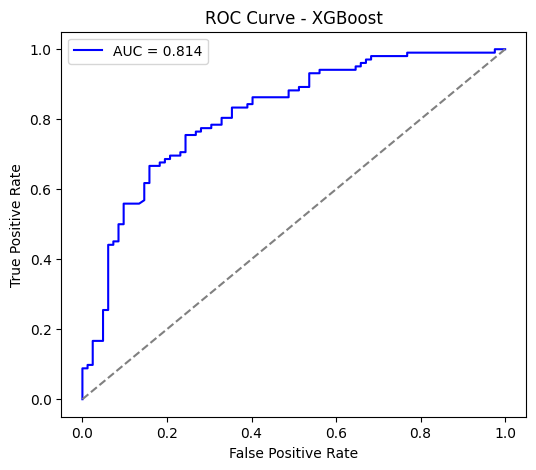

<Figure size 1000x600 with 0 Axes>

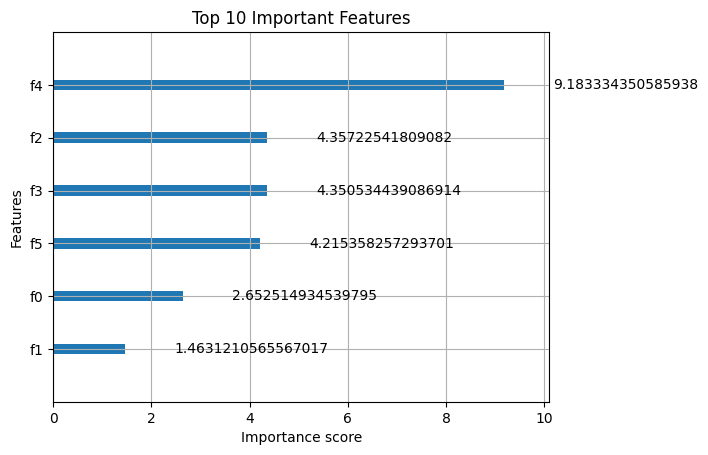

In [ ]:
# =========================================================
# XGBoost + GridSearchCV + ROC Curve + Feature Importance
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve
)
from xgboost import XGBClassifier, plot_importance

# ---------------------------------------------------------
# 1) Split the data
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------------------------------------
# 2) Pipeline: scaling + XGBoost
# ---------------------------------------------------------
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# ---------------------------------------------------------
# 3) LIGHT GridSearch parameters (for speed)
# ---------------------------------------------------------
param_grid = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0]
}

# ---------------------------------------------------------
# 4) GridSearchCV setup
# ---------------------------------------------------------
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# ---------------------------------------------------------
# 5) Fit on train data
# ---------------------------------------------------------
grid_xgb.fit(X_train, y_train)

# ---------------------------------------------------------
# 6) Results
# ---------------------------------------------------------
print("✅ Best Parameters Found:")
print(grid_xgb.best_params_)
print("\nBest CV Accuracy:", round(grid_xgb.best_score_, 4))

# ---------------------------------------------------------
# 7) Evaluate on Test set
# ---------------------------------------------------------
y_pred = grid_xgb.predict(X_test)
y_proba = grid_xgb.predict_proba(X_test)[:, 1]

print("\n🎯 Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("\nROC-AUC Score:", round(roc_auc_score(y_test, y_proba), 4))

# ---------------------------------------------------------
# 8) ROC Curve Plot
# ---------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

# ---------------------------------------------------------
# 9) Feature Importance Plot
# ---------------------------------------------------------
# Extract the best fitted model from pipeline
best_xgb = grid_xgb.best_estimator_.named_steps['xgb']

plt.figure(figsize=(10, 6))
plot_importance(best_xgb, max_num_features=10, importance_type='gain', title='Top 10 Important Features')
plt.show()
